# Web Scraping Agrolink with Python

In this notebook, we will be scraping crop prices from the Agrolink website. Interestingly, the website uses images to display the prices, which makes it harder to scrape the data. However, we can use a clever approach to handle this. Let's dive in!

<img src="agrolink_table.png" alt="table" width="600"/>

## Importing necessary libraries

First, we need to import the necessary libraries for our script.

In [18]:
from bs4 import BeautifulSoup
from io import BytesIO
from PIL import Image
import pandas as pd
import pytesseract
import requests
import re

## Defining helper function

We define a helper function `extract_urls_and_positions` to extract the URLs, positions and image size from the HTML content.

In [19]:
def extract_urls_and_positions(html):
    urlPattern = re.compile(r"url\('([^']+)'\);")
    positionPattern = re.compile(r"background-position:\s*(-?\d+)px\s*(-?\d+)px;")
    dimensionPattern = re.compile(r"width:\s*(\d+)px;\s*height:\s*(\d+)px;")

    urls = urlPattern.findall(html)
    positions = positionPattern.search(html)
    dimensions = dimensionPattern.search(html)

    return urls, (positions.group(1).removeprefix('-'), positions.group(2).removeprefix('-')) if positions else None, (dimensions.group(1), dimensions.group(2)) if dimensions else None,

## Scraping the data

Now, we start scraping the data from the Agrolink website. We use pandas to read the HTML tables from the URL and BeautifulSoup to parse the HTML content. Although pandas can read the table, it cannot read the values since they are images. That's why they need to be added to the dataframe after the OCR process.

In [20]:
urlSource = 'https://www.agrolink.com.br/cotacoes/graos/arroz/'

df = pd.read_html(urlSource)[0]

response = requests.get(urlSource)
htmlContent = response.text

soup = BeautifulSoup(htmlContent, 'html.parser')

# Processing the images

The website uses images to display the prices. Each price is a part of a larger image, and the website uses CSS to display only the relevant part of the image. We need to replicate this in our script to extract the prices. Below you can find one of the images as an example.

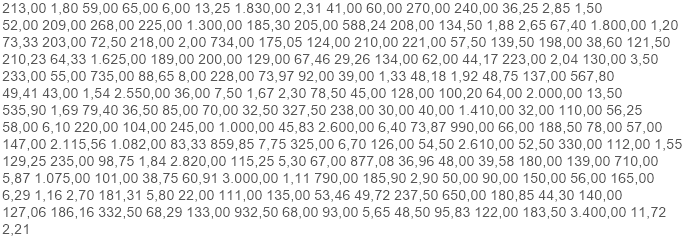

We find all div elements with the class 'text-right float-right', which contain the prices. For each div element, we extract the URL of the image, the position of the price in the image, and the dimensions of the price. We then send a GET request to the URL to get the image, open the image, convert it to RGBA, and crop it to get only the price. An example of a cropped image below.



Finally, we use pytesseract to perform Optical Character Recognition (OCR) on the cropped image to extract the price as text. We update our dataframe with the extracted price.

In [21]:
divElements = soup.find_all('div', class_='text-right float-right')

for idx, divElement in enumerate(divElements):
    htmlSnippet = str(divElement)
    urls, positions, dimensions = extract_urls_and_positions(htmlSnippet)

    url = urls[0]
    x = int(positions[0])
    y = int(positions[1])
    sizeX = int(dimensions[0])
    sizeY = int(dimensions[1])

    cropBox = (x, y, x+sizeX, y+sizeY)

    response = requests.get(url)

    image = Image.open(BytesIO(response.content))
    image = image.convert('RGBA')

    croppedImage = image.crop(cropBox)
    #croppedImage.save('croppedImage.png')

    valuePrice = pytesseract.image_to_string(croppedImage, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789,')

    df.at[idx+1, 'Preço (R$)'] = valuePrice.strip()

## Cleaning and saving the data

After extracting all the values we can clean the unecessary columns and remove the first row that only displays the current date.

Finally, we can print and save our dataframe to a CSV file.

In [22]:
df = df.iloc[:, :-2]
df = df.iloc[1:]

print(df.head(5))
df.to_csv('agrolink_arroz.csv',encoding='utf-8-sig')

                                             Produto  \
1     Arroz em Casca Irrigado Sc 60Kg Paranavaí (PR)   
2  Arroz em Casca Longo Fino Sc 60Kg Aliança do T...   
3  Arroz em Casca Longo Fino Sc 60Kg Aparecida do...   
4  Arroz em Casca Longo Fino Sc 60Kg Cariri do To...   
5  Arroz em Casca Longo Fino Sc 60Kg Formoso do A...   

                         Local Preço (R$) Última Atualização  
1               Paranavaí (PR)     171,67         26/12/2023  
2    Aliança do Tocantins (TO)     200,00         22/12/2023  
3  Aparecida do Rio Negro (TO)     200,00         22/12/2023  
4     Cariri do Tocantins (TO)     200,00         22/12/2023  
5     Formoso do Araguaia (TO)     200,00         22/12/2023  


## Conclusion

In this notebook, we successfully scraped crop prices from the Agrolink website, even though the website uses images to display the prices. We used a clever approach to handle this: we replicated the website's method of displaying only a part of the image, and we used OCR to extract the price as text. This shows that with a bit of creativity, we can overcome the challenges posed by websites that try to make it harder to scrape their data.
